In [48]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler


In [49]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/game_attention.csv")
# drop when attention is 0
games = games[games['attention'] > 0]
# adjust attention
# take log of attention
games['log_attention'] = np.log10(games['attention'])

games['gametime'] = games['gametime'].str.replace(':', '').astype(int)
games['date'] = pd.to_datetime(games['date'])

# games when ne is either home or away
ne_games = games[(games['home_team'] == 'NE') | (games['away_team'] == 'NE')]

ne_games['is_home'] = np.where(ne_games['home_team'] == 'NE', 1, 0)

# add column for the team they are playing against
ne_games['opponent'] = np.where(ne_games['is_home'] == 1, ne_games['away_team'], ne_games['home_team'])
ne_games.drop(columns=['home_team', 'away_team'], inplace=True)

# one hot encode weekday
ne_games = pd.get_dummies(ne_games, columns=['weekday', 'opponent'], drop_first=True)
ne_games



,date,game_id,season,week,gametime,home_win_pct,away_win_pct,num_lead_changes,total_score,score_differential,...,opponent_NYJ,opponent_OAK,opponent_PHI,opponent_PIT,opponent_SD,opponent_SEA,opponent_SF,opponent_TB,opponent_TEN,opponent_WAS
1,2013-09-08,2013_01_NE_BUF,2013,1,1300,0.000000,0.000000,2,44,2,...,False,False,False,False,False,False,False,False,False,False
16,2013-09-12,2013_02_NYJ_NE,2013,2,2025,1.000000,1.000000,0,23,3,...,True,False,False,False,False,False,False,False,False,False
38,2013-09-22,2013_03_TB_NE,2013,3,1300,1.000000,0.000000,1,26,20,...,False,False,False,False,False,False,False,True,False,False
61,2013-09-29,2013_04_NE_ATL,2013,4,2030,0.333333,1.000000,1,53,7,...,False,False,False,False,False,False,False,False,False,False
65,2013-10-06,2013_05_NE_CIN,2013,5,1300,0.500000,1.000000,0,19,7,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,2017-12-03,2017_13_NE_BUF,2017,13,1300,0.545455,0.818182,0,26,20,...,False,False,False,False,False,False,False,False,False,False
1231,2017-12-11,2017_14_NE_MIA,2017,14,2030,0.416667,0.833333,2,47,7,...,False,False,False,False,False,False,False,False,False,False
1244,2017-12-17,2017_15_NE_PIT,2017,15,1625,0.846154,0.769231,2,51,3,...,False,False,False,True,False,False,False,False,False,False
1254,2017-12-24,2017_16_BUF_NE,2017,16,1300,0.785714,0.571429,3,53,21,...,False,False,False,False,False,False,False,False,False,False


In [50]:
X = ne_games.drop(columns=['attention', 'log_attention', 'date', 'game_id'])
y = ne_games['log_attention']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')




Mean Squared Error: 1.309120047877601
R^2 Score: -6.188424516831391


Mean Squared Error: 0.12209670904306055
R^2 Score: 0.3295626492524494


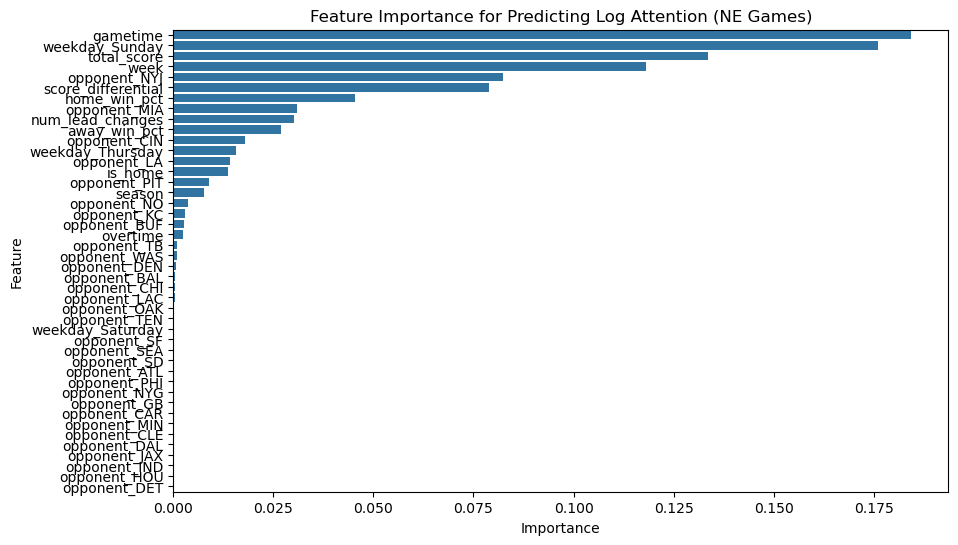

In [51]:
# XG BOOST to predict attention with only NE games
from xgboost import XGBRegressor
X = ne_games.drop(columns=['attention', 'log_attention', 'date', 'game_id'])
y = ne_games['log_attention']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBRegressor(objective ='reg:squarederror', n_estimators=1000, learning_rate=0.01)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
# feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Log Attention (NE Games)')
plt.show()


